# **Import libraries**

In [1]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Standard Library Imports
from ast import literal_eval

# Text Processing Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning and Metrics Libraries
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


# **Read dataset**

In [2]:
df1=pd.read_csv(r'tmdb_5000/tmdb_5000_credits.csv')

df1.columns = ['id','title','cast','crew']

df2=pd.read_csv(r'tmdb_5000/tmdb_5000_movies.csv')

df= df1.merge(df2,on=['id','title'])

df.drop(['homepage'],axis=1,inplace=True)

df['tagline'] = df['tagline'].fillna('')
df['overview'] = df['overview'].fillna('')

df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['id', 'title'], inplace=True)

df['year'] = df['year'].astype(int)

## dataframe information

In [3]:
print(f'Shape of the dataframe: {df.shape}')

print('\n')

print(f'columns: {df.columns}')

Shape of the dataframe: (4800, 22)


columns: Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'vote_average', 'vote_count', 'year'],
      dtype='object')


In [4]:
print(f'Information about the dataframe: \n{df.info()}')

<class 'pandas.core.frame.DataFrame'>
Index: 4800 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4800 non-null   int64  
 1   title                 4800 non-null   object 
 2   cast                  4800 non-null   object 
 3   crew                  4800 non-null   object 
 4   budget                4800 non-null   int64  
 5   genres                4800 non-null   object 
 6   keywords              4800 non-null   object 
 7   original_language     4800 non-null   object 
 8   original_title        4800 non-null   object 
 9   overview              4800 non-null   object 
 10  popularity            4800 non-null   float64
 11  production_companies  4800 non-null   object 
 12  production_countries  4800 non-null   object 
 13  release_date          4800 non-null   object 
 14  revenue               4800 non-null   int64  
 15  runtime               4800

In [5]:
df.head(2)

,id,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,year
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,2009
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,2007


# **Knowledge based Recommender**

In [6]:
df['genres'] = df['genres'].apply(literal_eval)
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df['production_countries'] = df['production_countries'].apply(literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df['production_companies'] = df['production_companies'].apply(literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df['cast'] = df['cast'].apply(literal_eval)
df['crew'] = df['crew'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(literal_eval)
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

In [7]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

df['director'] = df['crew'].apply(get_director)

In [8]:
df['actor'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['actor'] = df['actor'].apply(lambda x: x[:3] if len(x) >=3 else x)

df['character'] = df['cast'].apply(lambda x: [i['character'] for i in x] if isinstance(x, list) else [])
df['character'] = df['character'].apply(lambda x: x[:3] if len(x) >=3 else x)

df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [9]:
movies_df = df[['id', 'title', 'year', 'genres', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue', 'original_language', 'production_countries', 'runtime',
        'production_companies', 'director', 'actor', 'character', 'cast_size', 'crew_size', 'overview', 'tagline', 'keywords']]

In [10]:
print(f'Shape of the movies dataframe: {movies_df.shape}')

movies_df.head(2)

Shape of the movies dataframe: (4800, 21)


,id,title,year,genres,vote_average,vote_count,popularity,budget,revenue,original_language,...,runtime,production_companies,director,actor,character,cast_size,crew_size,overview,tagline,keywords
0,19995,Avatar,2009,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,237000000,2787965087,en,...,162.0,"[Ingenious Film Partners, Twentieth Century Fo...",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Jake Sully, Neytiri, Dr. Grace Augustine]",83,153,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon..."
1,285,Pirates of the Caribbean: At World's End,2007,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,300000000,961000000,en,...,169.0,"[Walt Disney Pictures, Jerry Bruckheimer Films...",Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[Captain Jack Sparrow, Will Turner, Elizabeth ...",34,32,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ..."


## **Knowledge based Visualization**

In [11]:
avg_highly_rated_movies = movies_df[['title', 'vote_average', 'vote_count']]
avg_highly_rated_movies.head(2)

,title,vote_average,vote_count
0,Avatar,7.2,11800
1,Pirates of the Caribbean: At World's End,6.9,4500


In [12]:
print("Number of movies with 5 star rating on average: ",len(avg_highly_rated_movies[avg_highly_rated_movies['vote_average'] == 10.0]))
print("Number of movies with above 4 star and below 5 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_average'] >= 8.0) & (avg_highly_rated_movies['vote_average'] < 10.0)]))
print("Number of movies with above 3 star and below 4 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_average'] >= 6.0) & (avg_highly_rated_movies['vote_average'] < 8.0)]))
print("Number of movies with above 2 star and below 3 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_average'] >= 4.0) & (avg_highly_rated_movies['vote_average'] < 6.0)]))
print("Number of movies with above 1 star and below 2 star rating on average: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_average'] >= 2.0) & (avg_highly_rated_movies['vote_average'] < 4.0)]))
print("Number of movies with below 1 star rating on average: ", len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_average'] < 2.0)]))


Number of movies with 5 star rating on average:  4
Number of movies with above 4 star and below 5 star rating on average:  81
Number of movies with above 3 star and below 4 star rating on average:  2886
Number of movies with above 2 star and below 3 star rating on average:  1659
Number of movies with above 1 star and below 2 star rating on average:  105
Number of movies with below 1 star rating on average:  65


In [13]:
print('Split of movies count based on their overall average rating')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '5 star', '4 to 5 star', '3 to 4 star', '2 to 3 star', '1 to 2 star', '0 to 1 star'
values = [4, 81, 2886, 1659, 105, 66]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

Split of movies count based on their overall average rating


In [14]:
top_avg_highly_rated_movies = avg_highly_rated_movies[avg_highly_rated_movies['vote_count'] >= 1000].sort_values('vote_average', ascending=False)
top_avg_highly_rated_movies.head(10)

,title,vote_average,vote_count
1881,The Shawshank Redemption,8.5,8205
3337,The Godfather,8.4,5893
3232,Pulp Fiction,8.3,8428
2294,Spirited Away,8.3,3840
2731,The Godfather: Part II,8.3,3338
1818,Schindler's List,8.3,4329
3865,Whiplash,8.3,4254
662,Fight Club,8.3,9413
1987,Howl's Moving Castle,8.2,1991
3719,One Flew Over the Cuckoo's Nest,8.2,2919


In [15]:
print("Number of popular movies with more than 5000 voter count: ",len(avg_highly_rated_movies[avg_highly_rated_movies['vote_count'] >= 5000]))
print("Number of popular movies with more than 4000 and less than 5000 voter count: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] >= 4000) & (avg_highly_rated_movies['vote_count'] < 5000)]))
print("Number of popular movies with more than 3000 and less than 4000 voter count: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] >= 3000) & (avg_highly_rated_movies['vote_count'] < 4000)]))
print("Number of popular movies with more than 2000 and less than 3000 voter count: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] >= 2000) & (avg_highly_rated_movies['vote_count'] < 3000)]))
print("Number of popular movies with more than 1000 and less than 2000 voter count: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] >= 1000) & (avg_highly_rated_movies['vote_count'] < 2000)]))
print("Number of popular movies with more than 500 and less than 1000 voter count: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] >= 500) & (avg_highly_rated_movies['vote_count'] < 1000)]))
print("Number of popular movies with more than 100 and less than 500 voter count: ",len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] >= 100) & (avg_highly_rated_movies['vote_count'] < 500)]))
print("Number of popular movies with less than 100 voter count: ", len(avg_highly_rated_movies[(avg_highly_rated_movies['vote_count'] < 100)]))

Number of popular movies with more than 5000 voter count:  84
Number of popular movies with more than 4000 and less than 5000 voter count:  67
Number of popular movies with more than 3000 and less than 4000 voter count:  97
Number of popular movies with more than 2000 and less than 3000 voter count:  185
Number of popular movies with more than 1000 and less than 2000 voter count:  491
Number of popular movies with more than 500 and less than 1000 voter count:  688
Number of popular movies with more than 100 and less than 500 voter count:  1550
Number of popular movies with less than 100 voter count:  1638


In [16]:
print('Split of movies count based on their overall average rating')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '5000 voter count', '4000 to 5000 voter count', '3000 to 4000 voter count', '2000 to 3000 voter count', '1000 to 2000 voter count', '500 to 1000 voter count', '100 to 500 voter count', 'Less than 100 voter count'
values = [84, 67, 97, 185, 491, 688, 1550, 1639]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

Split of movies count based on their overall average rating


### Recommendations based on Movie Genre to a New User.

In [17]:
genres_highly_rated_movies = movies_df[['id','title', 'genres', 'vote_average', 'vote_count']]
genres_highly_rated_movies.head(2)

,id,title,genres,vote_average,vote_count
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500


In [18]:
genres_highly_rated_movies = genres_highly_rated_movies[genres_highly_rated_movies['vote_count'] >= 1000].sort_values('vote_average', ascending=False)
print(genres_highly_rated_movies.shape)
genres_highly_rated_movies.head(2)

(924, 5)


,id,title,genres,vote_average,vote_count
1881,278,The Shawshank Redemption,"[Drama, Crime]",8.5,8205
3337,238,The Godfather,"[Drama, Crime]",8.4,5893


In [19]:
# Extract unique genres
unique_genres = set(genre for genres in genres_highly_rated_movies['genres'] for genre in genres)

# Create a column for each genre with binary encoding
for genre in unique_genres:
    genres_highly_rated_movies[genre] = genres_highly_rated_movies['genres'].apply(lambda genres: 1 if genre in genres else 0)

# Drop the original genres column if no longer needed
genres_highly_rated_movies = genres_highly_rated_movies.drop(columns=['genres'])


In [20]:
print(genres_highly_rated_movies.shape)
genres_highly_rated_movies.head(2)

(924, 22)


,id,title,vote_average,vote_count,Action,Thriller,Science Fiction,TV Movie,Western,Crime,...,War,Music,History,Animation,Fantasy,Comedy,Drama,Romance,Horror,Family
1881,278,The Shawshank Redemption,8.5,8205,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3337,238,The Godfather,8.4,5893,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [21]:
movie_genre_list = genres_highly_rated_movies.columns[4:].tolist()
movie_genre_list

['Action',
 'Thriller',
 'Science Fiction',
 'TV Movie',
 'Western',
 'Crime',
 'Mystery',
 'Adventure',
 'War',
 'Music',
 'History',
 'Animation',
 'Fantasy',
 'Comedy',
 'Drama',
 'Romance',
 'Horror',
 'Family']

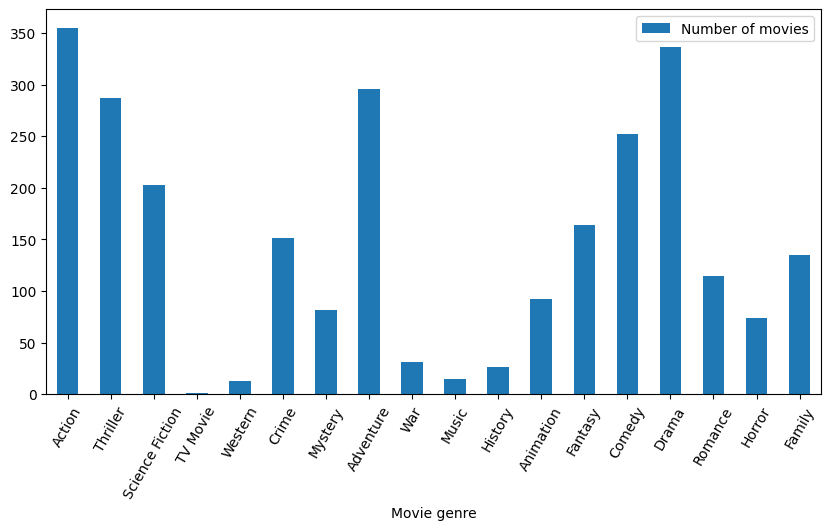

In [22]:
count = []
for i in movie_genre_list:
    # print(i)
    genre_based_movies = genres_highly_rated_movies[['id','title',i]]
    genre_based_movies = genre_based_movies[genre_based_movies[i] == 1]
    count.append(len(genre_based_movies))
    # merged_genre_movies = pd.merge(dataset, genre_based_movies, how='inner', on='movie id')
    # star_based_visualization(merged_genre_movies)
df_plot = pd.DataFrame({'Movie genre':movie_genre_list, 'Number of movies':count})
ax = df_plot.plot.bar(x='Movie genre', y='Number of movies', rot=60, figsize=(10, 5))

# **Demographic Filtering**

![](https://image.ibb.co/jYWZp9/wr.png)

### where

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

In [23]:
C= df['vote_average'].mean()
print(f'Mean vote across the whole report: {C}')

m= df['vote_count'].quantile(0.85)
print(f'Minimum votes required to be listed in the chart: {m}')

Mean vote across the whole report: 6.094458333333334
Minimum votes required to be listed in the chart: 1301.3000000000002


In [24]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [25]:
q_movies = df.copy().loc[df['vote_count'] >= m]
print(f'shape of the filtered dataframe: {q_movies.shape}')

shape of the filtered dataframe: (720, 27)


In [26]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [27]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.170710
662,Fight Club,9413,8.3,8.032127
3232,Pulp Fiction,8428,8.3,8.005007
65,The Dark Knight,12002,8.2,7.994040
3337,The Godfather,5893,8.4,7.982975
96,Inception,13752,8.1,7.926629
809,Forrest Gump,7927,8.2,7.903094
95,Interstellar,10867,8.1,7.885524
329,The Lord of the Rings: The Return of the King,8064,8.1,7.821332
1990,The Empire Strikes Back,5879,8.2,7.818409


Text(0.5, 1.0, 'Popular Movies')

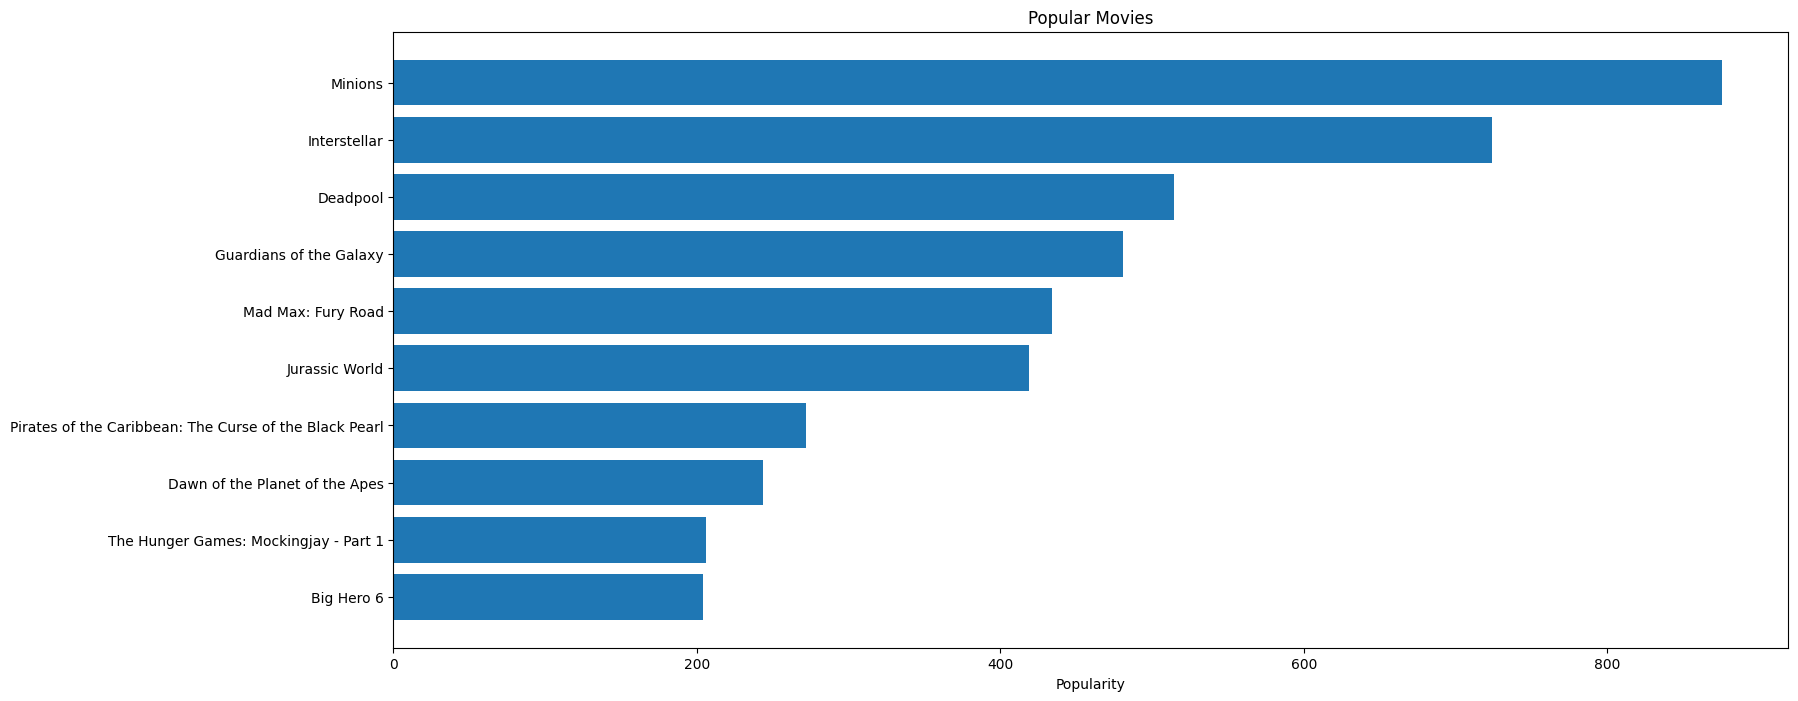

In [28]:
pop= q_movies.sort_values('popularity', ascending=False)

plt.figure(figsize=(18,8))
plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


# **Content Based Filtering**

In [29]:
df['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [30]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4800, 20977)

## **Cosine similarity**

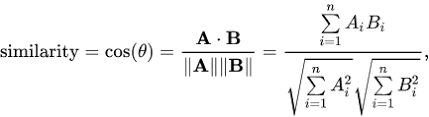

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [31]:
# Compute the cosine similarity matrix
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim_1 = cosine_similarity(tfidf_matrix, tfidf_matrix)

cosine_sim_1.shape

(4800, 4800)

In [32]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

indices.head()

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

In [33]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim, recommendations_num=10):
    
    recommendations_num = recommendations_num + 1
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:recommendations_num]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [34]:
get_recommendations('The Dark Knight Rises', cosine_sim_1)

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [35]:
get_recommendations('The Avengers', cosine_sim_1)

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

# **Credits, Genres and Keywords Based Recommender**

In [36]:
df1=pd.read_csv(r'tmdb_5000/tmdb_5000_credits.csv')

df1.columns = ['id','title','cast','crew']

df2=pd.read_csv(r'tmdb_5000/tmdb_5000_movies.csv')

df= df1.merge(df2,on=['id','title'])

df.drop(['homepage'],axis=1,inplace=True)

df['tagline'] = df['tagline'].fillna('')
df['overview'] = df['overview'].fillna('')

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['id', 'title'], inplace=True)

df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['year'] = df['year'].astype(int)

In [37]:
# convert the column into a safe and usable structure form of "stringified"
# Parse the stringified features into their corresponding python objects
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [38]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [39]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [40]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(get_list)

In [41]:
# Print the new features of the first 3 films
df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [42]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [43]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

df['clean_title'] = df['title'].apply(lambda x: x.lower().split())

In [44]:
# Print the new features of the first 3 films
df[['title', 'clean_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,clean_title,cast,director,keywords,genres
0,Avatar,[avatar],"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[pirates, of, the, caribbean:, at, world's, end]","[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,[spectre],"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"


In [45]:
def create_soup(x):
    return ' '.join(x['clean_title']) + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df['soup'] = df.apply(create_soup, axis=1)

In [46]:
print(df['soup'].loc[0])

df['soup'].head(3)

avatar cultureclash future spacewar samworthington zoesaldana sigourneyweaver jamescameron action adventure fantasy


0    avatar cultureclash future spacewar samworthin...
1    pirates of the caribbean: at world's end ocean...
2    spectre spy basedonnovel secretagent danielcra...
Name: soup, dtype: object

## **CountVectorizer()**

In [47]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

count_matrix.shape

(4800, 15189)

In [48]:
# Compute the Cosine Similarity matrix based on the count_matrix

cosine_sim_2 = cosine_similarity(count_matrix, count_matrix)
# cosine_sim_2 = linear_kernel(count_matrix, count_matrix)

cosine_sim_2.shape

(4800, 4800)

In [49]:
get_recommendations('The Dark Knight Rises', cosine_sim_2)

65                              The Dark Knight
119                               Batman Begins
4638                   Amidst the Devil's Wings
1196                               The Prestige
2609                                  Dark Blue
3073                          Romeo Is Bleeding
535                                First Knight
3854    Batman: The Dark Knight Returns, Part 2
1503                                     Takers
1986                                     Faster
Name: title, dtype: object

In [50]:
get_recommendations('The Avengers', cosine_sim_2)

7                   Avengers: Age of Ultron
26               Captain America: Civil War
79                               Iron Man 2
174                     The Incredible Hulk
169      Captain America: The First Avenger
85      Captain America: The Winter Soldier
203                                      X2
511                                   X-Men
1294                               Serenity
31                               Iron Man 3
Name: title, dtype: object

## Using only Numerical column for **Content Based Filtering**

In [51]:
df.head(3)

,id,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,year,director,clean_title,soup
0,19995,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[action, adventure, fantasy]","[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,2009,jamescameron,[avatar],avatar cultureclash future spacewar samworthin...
1,285,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[adventure, fantasy, action]","[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,2007,goreverbinski,"[pirates, of, the, caribbean:, at, world's, end]",pirates of the caribbean: at world's end ocean...
2,206647,Spectre,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[action, adventure, crime]","[spy, basedonnovel, secretagent]",en,Spectre,A cryptic message from Bond’s past sends him o...,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466,2015,sammendes,[spectre],spectre spy basedonnovel secretagent danielcra...


In [52]:
ndf = df.select_dtypes(include=["float64","int64","float32","int32"])

ndf.drop(columns=['id'], inplace=True)

print(f'ndf shape is: {ndf.shape}')

ndf.head()

ndf shape is: (4800, 7)


,budget,popularity,revenue,runtime,vote_average,vote_count,year
0,237000000,150.437577,2787965087,162.0,7.2,11800,2009
1,300000000,139.082615,961000000,169.0,6.9,4500,2007
2,245000000,107.376788,880674609,148.0,6.3,4466,2015
3,250000000,112.312950,1084939099,165.0,7.6,9106,2012
4,260000000,43.926995,284139100,132.0,6.1,2124,2012


In [53]:
# Create MinMaxScaler Object
scaler = MinMaxScaler(feature_range=(0, 1))

# Create dataframe after transformation
ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))

# assign column names
ndfmx.columns=ndf.columns

# Show initial 5 records
ndfmx.head()


,budget,popularity,revenue,runtime,vote_average,vote_count,year
0,0.623684,0.171814,1.000000,0.479290,0.72,0.858057,0.920792
1,0.789474,0.158846,0.344696,0.500000,0.69,0.327225,0.900990
2,0.644737,0.122634,0.315884,0.437870,0.63,0.324753,0.980198
3,0.657895,0.128272,0.389151,0.488166,0.76,0.662158,0.950495
4,0.684211,0.050169,0.101916,0.390533,0.61,0.154450,0.950495


In [54]:
# Compute the cosine similarity
cosine_sim_3 = cosine_similarity(ndfmx, ndfmx)

cosine_sim_3.shape

(4800, 4800)

In [55]:
# Reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

print(f'Indices shape is: {indices.shape}')
indices.head()

Indices shape is: (4800,)


title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

In [56]:
get_recommendations('The Dark Knight', cosine_sim_3)

96                                             Inception
16                                          The Avengers
68                                              Iron Man
3                                  The Dark Knight Rises
31                                            Iron Man 3
262    The Lord of the Rings: The Fellowship of the Ring
197             Harry Potter and the Philosopher's Stone
29                                               Skyfall
287                                     Django Unchained
199    Pirates of the Caribbean: The Curse of the Bla...
Name: title, dtype: object

# **Marge two cosine similarity matrices**

In [57]:
alpha = 0.3  # Hyperparameter to balance the two matrices

combined_sim = alpha * cosine_sim_1 + (1 - alpha) * cosine_sim_2

combined_sim.shape

(4800, 4800)

In [58]:
get_recommendations('The Dark Knight Rises', combined_sim)

65                              The Dark Knight
119                               Batman Begins
3854    Batman: The Dark Knight Returns, Part 2
299                              Batman Forever
1196                               The Prestige
4638                   Amidst the Devil's Wings
2609                                  Dark Blue
3073                          Romeo Is Bleeding
535                                First Knight
1359                                     Batman
Name: title, dtype: object

In [59]:
get_recommendations('The Avengers', combined_sim)

7                   Avengers: Age of Ultron
26               Captain America: Civil War
174                     The Incredible Hulk
79                               Iron Man 2
169      Captain America: The First Avenger
85      Captain America: The Winter Soldier
511                                   X-Men
203                                      X2
1294                               Serenity
182                                 Ant-Man
Name: title, dtype: object